# Setup

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import (
    classification_report,
    roc_curve,
    confusion_matrix,
    auc,
)

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
BASE_PATH = 'Pretrained_Data'
FILE_PATH = 'MRI_Data'
TEST_DIR = os.path.join(BASE_PATH, 'Testing')
TRAIN_DIR = os.path.join(BASE_PATH, 'Training')
METADATA_PATH = os.path.join(FILE_PATH, 'mri_metadata.csv')

IMG_SIZE = 256
IMG_CHANNELS = 3

class_names = ["glioma","meningioma","notumor","pituitary"]

metadata_df = pd.read_csv(METADATA_PATH)
print(f"metadata_df shape: {metadata_df.shape}")

metadata_df shape: (7023, 3)


## Helper Functions

In [4]:
def test(network, test_loader, loss_function):
  network.eval() #updates any network layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      data = data.to(device)
      target = target.to(device)
        
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
    
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

def graphConfusionMatrix(test_datset, num_samples=10000):
  data_generator = torch.utils.data.DataLoader(test_datset, batch_size=num_samples)
  data_enumerator = enumerate(data_generator)
  _, (images,labels) = next(data_enumerator)
  with torch.no_grad():
      pred_catigories = network(images) #all 10 values
      pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
  conf_mat = confusion_matrix(labels.numpy(), pred_labels.numpy(), normalize = "pred")
  plt.figure(figsize=(8,5))
  sns.heatmap(conf_mat, annot=True, fmt="0.2f", xticklabels = classes, yticklabels = classes,
              cmap = "gnuplot") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
  plt.xlabel("Target Class")
  plt.ylabel("Predicted Class")

In [5]:
def train(network,  data_generator, loss_function, optimizer, batch_logging = 100):
  network.train() #updates any network layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for batch, (input_data, target_output) in enumerate(data_generator):
    input_data = input_data.to(device)
    target_output = target_output.to(device)
    
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = network(input_data)                 # Forward pass: compute the output class given a image)
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
    if ((batch+1)%batch_logging == 0): #Print info every "batch_logging" steps [NEW]
      print('Batch [%d/%d], Train Loss: %.4f' %(batch+1, len(data_generator.dataset)/len(target_output), avg_loss/num_batches))
  return avg_loss/num_batches

In [6]:
def trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, early_stopping=True, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []
  last_loss = 999999
  best_loss = 999999
  for epoch in range(num_epochs):
    avg_loss = train(network, training_generator, loss_function, optimizer)
    test_loss = test(network, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)
    if (early_stopping and test_loss > last_loss):
      break
    if (test_loss < best_loss):
      best_loss = test_loss
      torch.save(network.state_dict(), 'best_model.pt')
    last_loss = test_loss
    old_params = network.parameters()

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

# Image Processing

In [7]:
class MRICropDataset(Dataset):
    def __init__(self, metadata_df, base_dir, split, transform=None):
        self.df = metadata_df[metadata_df['split'] == split].reset_index(drop=True)
        self.base_dir = base_dir
        self.transform = transform
        self.class_to_idx = {cls: i for i, cls in enumerate(self.df['dx'].unique())}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        class_folder = row['dx']
        path = os.path.join(self.base_dir, class_folder, row['image_id'])
        label = self.class_to_idx[row['dx']]
        
        img = Image.open(path).convert("RGB")
        img = self.crop_mri(img)
        
        if self.transform:
            img = self.transform(img)
        return img, label
    
    @staticmethod
    def crop_mri(img):
        arr = np.array(img)
        mask = arr.sum(axis=2) > 0  # non-black pixels
        coords = np.argwhere(mask)
        if coords.size == 0:
            return img
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0) + 1
        cropped = arr[y0:y1, x0:x1, :]
        return Image.fromarray(cropped)

In [28]:
class MRIDataset(torch.utils.data.Dataset):
    def __init__(self, metadata_df, base_dir, split, transform=None):
        self.df = metadata_df[metadata_df['split'] == split].reset_index(drop=True)
        self.base_dir = base_dir
        self.transform = transform
        self.class_to_idx = {cls: i for i, cls in enumerate(self.df['dx'].unique())}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        class_folder = row['dx']
        path = os.path.join(self.base_dir, class_folder, row['image_id'])
        label = self.class_to_idx[row['dx']]
        
        img = Image.open(path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        return img, label

# Multiclass KNN Model

In [9]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

test_dataset  = MRICropDataset(metadata_df, TEST_DIR, split='Testing', transform=transform)
train_dataset = MRICropDataset(metadata_df, TRAIN_DIR, split='Training', transform=transform)

In [10]:
def dataset_to_numpy(dataset):
    X_list, y_list = [], []
    for img, label in dataset:
        X_list.append(img.view(-1))
        y_list.append(label)
    X = torch.stack(X_list).numpy()
    y = np.array(y_list)
    return X, y

X_train, y_train = dataset_to_numpy(train_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

In [11]:
# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [12]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k, weights = 'distance')
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

## Results

In [13]:
# General accuracy and class-based precision, recall, and f1-score
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.90      0.96      0.93       300
  meningioma       0.96      0.87      0.91       306
     notumor       0.98      0.99      0.99       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



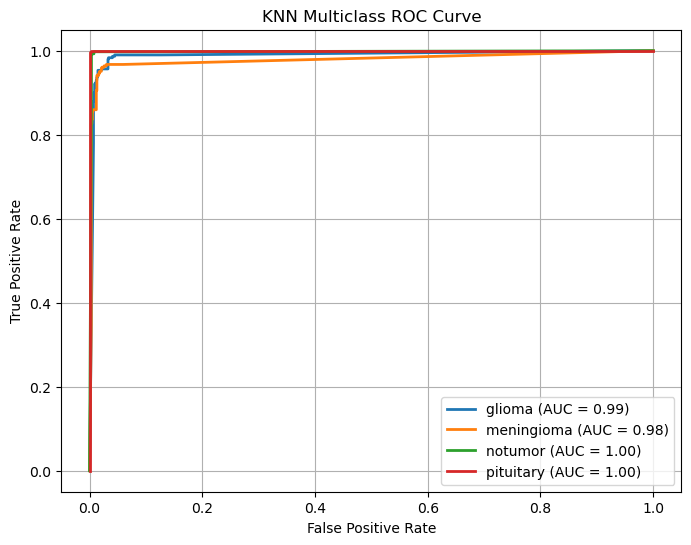

In [14]:
# Class-based ROC AUC graph

# Binarize the test labels
y_test_bin = label_binarize(y_test, classes=[0,1,2,3])
y_prob = knn.predict_proba(X_test_scaled)

plt.figure(figsize=(8, 6))

for i, cls_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls_name} (AUC = {roc_auc:.2f})")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

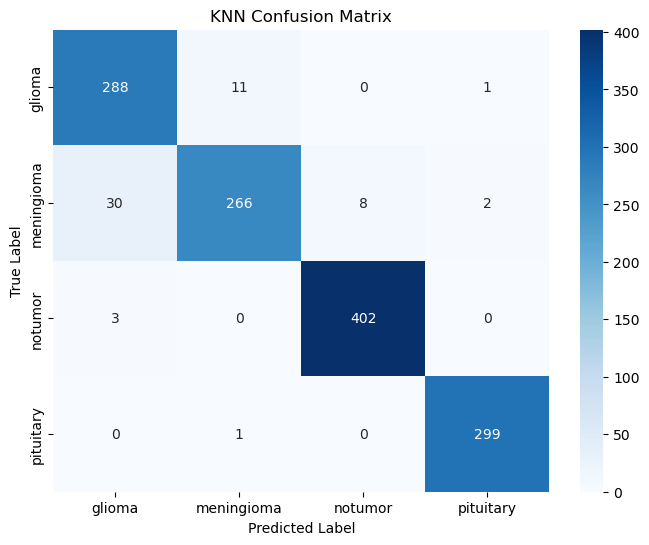

In [15]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("KNN Confusion Matrix")
plt.show()

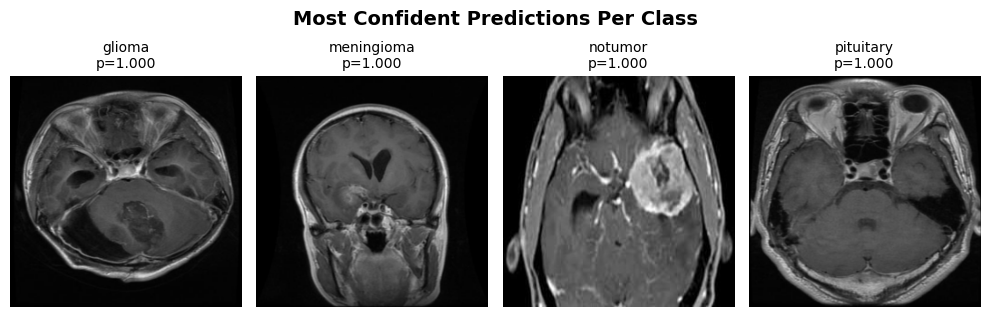

In [16]:
# Most Confident Predictions Per Class

max_conf = {cls: 0 for cls in range(len(class_names))}
max_image = {cls: None for cls in range(len(class_names))}
max_image_idx = {cls: None for cls in range(len(class_names))}

for i in range(len(X_test)):
    for cls in range(len(class_names)):
        conf = y_prob[i, cls]
        if conf > max_conf[cls]:
            max_conf[cls] = conf
            max_image[cls] = X_test[i]
            max_image_idx[cls] = i

fig, axes = plt.subplots(1, len(class_names), figsize=(10, 3))

for cls in range(len(class_names)):
    img = max_image[cls]
    img = img.reshape(IMG_CHANNELS, IMG_SIZE, IMG_SIZE).transpose(1, 2, 0)

    axes[cls].imshow(img)
    axes[cls].set_title(f"{class_names[cls]}\np={max_conf[cls]:.3f}", fontsize=10)
    axes[cls].axis("off")

plt.tight_layout()
plt.suptitle("Most Confident Predictions Per Class", y=1.1, fontsize=14, fontweight='bold')
plt.show()


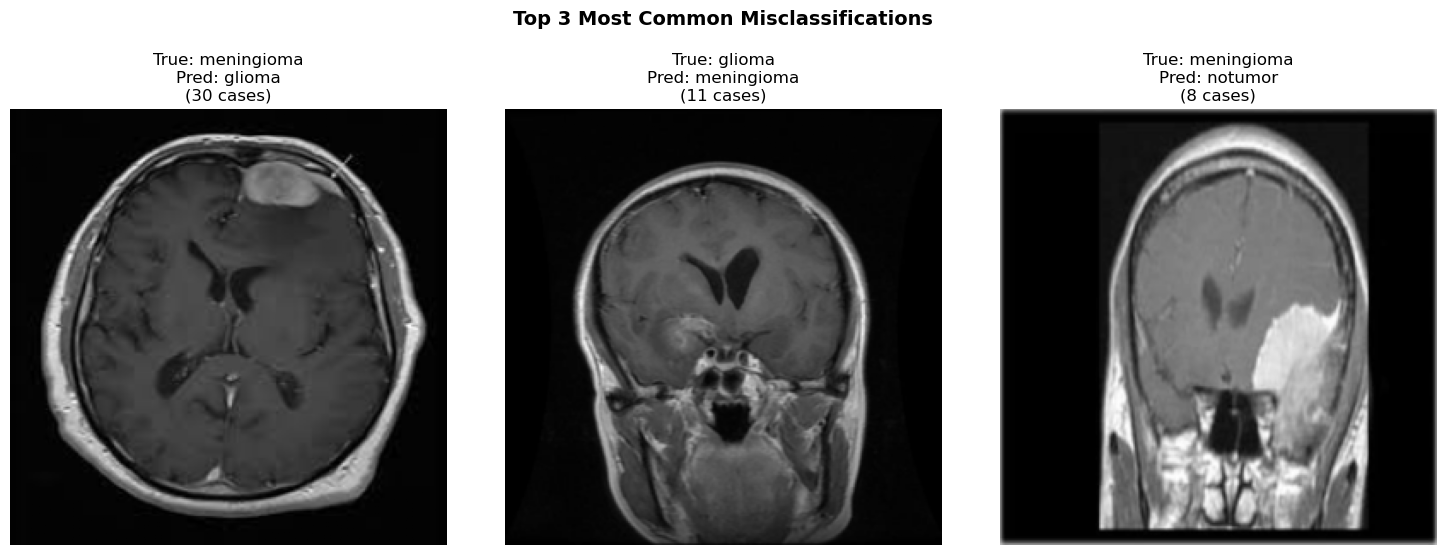

In [17]:
# Top 3 Most Common Misclassifications

misclass_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and conf_mat[i, j] > 0:
            misclass_pairs.append((conf_mat[i, j], i, j))

misclass_pairs.sort(reverse=True)
top_3_misclass = misclass_pairs[:3]

misclass_examples = {}
for idx in range(len(y_test)):
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    key = (true_label, pred_label)
    if key in [(t, p) for _, t, p in top_3_misclass] and key not in misclass_examples:
        misclass_examples[key] = X_test[idx]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (count, true_cls, pred_cls) in enumerate(top_3_misclass):
    key = (true_cls, pred_cls)
    if key in misclass_examples:
        img = misclass_examples[key].reshape(IMG_CHANNELS, IMG_SIZE, IMG_SIZE).transpose(1, 2, 0)
        axes[idx].imshow(img)
        axes[idx].set_title(f"True: {class_names[true_cls]}\nPred: {class_names[pred_cls]}\n({count} cases)")
        axes[idx].axis("off")
    else:
        axes[idx].text(0.5, 0.5, 'No example found', ha='center', va='center')
        axes[idx].axis("off")

plt.tight_layout()
plt.suptitle("Top 3 Most Common Misclassifications", y=1.1, fontsize=14, fontweight='bold')
plt.show()

# CNN Model

In [29]:
# Define transforms
transform = transforms.Compose([
       transforms.Resize((512, 512)),
       transforms.ToTensor(),
       transforms.RandomHorizontalFlip(p=0.5), #data augmentation
       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalize: rgb value
   ])

training_dataset = MRIDataset(metadata_df, TRAIN_DIR, split='Training', transform=transform)
testing_dataset = MRIDataset(metadata_df, TEST_DIR, split='Testing', transform=transform)

training_generator = DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=2)
testing_generator = DataLoader(testing_dataset, batch_size=32, shuffle=False, num_workers=2)

In [30]:
class CNN_Best(nn.Module):
    def __init__(self, img_w, img_h, num_classes): #lets assume 32x32 image, hidden_channels = 8
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3) 
        self.conv2 = nn.Conv2d(32, 64, 3) 
        self.conv3 = nn.Conv2d(64, 64, 3)
        new_img_w = 25; new_img_h = 25
        self.flattened_dim = new_img_w * new_img_h * 64       
        self.linear1 = nn.Linear(self.flattened_dim, 20000) 
        self.linear2 = nn.Linear(20000, 1000)
        self.linear3 = nn.Linear(1000, num_classes)
        #Implement the above archetucure

    def forward(self, x):
        x = self.conv1(x) #510x510x32
        x = F.relu(x)
        
        x = self.conv2(x) #508x508x64
        
        x = F.max_pool2d(x,kernel_size=2) #254x254x64
        
        x = F.max_pool2d(x,kernel_size=2) #127x127x64
        x = F.relu(x)
        
        x = self.conv3(x) #125x125x64
        x = F.relu(x)
        
        x = F.max_pool2d(x, kernel_size=5) #25x25x64
        
        x = x.view(-1, self.flattened_dim)
        
        x = F.relu(self.linear1(x))
        
        x = self.linear2(x)
        
        x = self.linear3(x)
        
        return x


In [31]:
# Source - https://stackoverflow.com/a
# Posted by behnaz.sheikhi, modified by community. See post 'Timeline' for change history
# Retrieved 2025-12-09, License - CC BY-SA 4.0

import gc

gc.collect()

torch.cuda.empty_cache()

## CNN Model Training

Batch [100/714], Train Loss: 2.9642
Batch [200/714], Train Loss: 1.8795
Batch [300/714], Train Loss: 1.4720
Batch [400/714], Train Loss: 1.2440
Batch [500/714], Train Loss: 1.1095
Batch [600/714], Train Loss: 1.0215
Batch [700/714], Train Loss: 0.9466
Epoch [1/10], Train Loss: 0.9354, Test Loss: 0.5486
Batch [100/714], Train Loss: 0.3695
Batch [200/714], Train Loss: 0.3910
Batch [300/714], Train Loss: 0.3906
Batch [400/714], Train Loss: 0.3898
Batch [500/714], Train Loss: 0.3810
Batch [600/714], Train Loss: 0.3838
Batch [700/714], Train Loss: 0.3800
Epoch [2/10], Train Loss: 0.3776, Test Loss: 0.4076
Batch [100/714], Train Loss: 0.2955
Batch [200/714], Train Loss: 0.2782
Batch [300/714], Train Loss: 0.2733
Batch [400/714], Train Loss: 0.2841
Batch [500/714], Train Loss: 0.2767
Batch [600/714], Train Loss: 0.2754
Batch [700/714], Train Loss: 0.2761
Epoch [3/10], Train Loss: 0.2755, Test Loss: 0.2604
Batch [100/714], Train Loss: 0.2361
Batch [200/714], Train Loss: 0.2146
Batch [300/714],

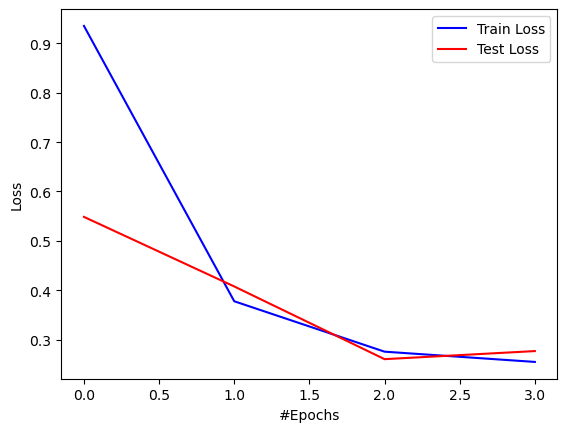

In [32]:
#Training parameters
num_epochs = 10
print_interval = 1
learning_rate = 0.001
batch_size = 8
image_w = 512
image_h = 512
#Create model
network = CNN_Best(image_w, image_h, 4).to(device)

#Set optimizer and loss function
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate, weight_decay=1e-6)#, weight_decay=1e-6)#L2 Regularization with weight_decay > 0: tried using it with
loss_function = nn.CrossEntropyLoss()

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

computeLabelAccuracy(network, training_generator, "Train Set")
computeLabelAccuracy(network, testing_generator, "Test Set")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1333334].


<class 'torch.Tensor'>


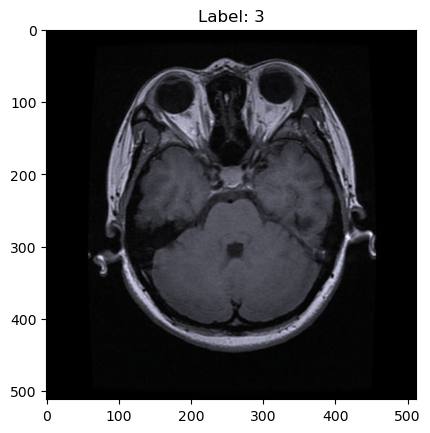

In [33]:
data_iter = iter(training_generator)
images, labels = next(data_iter)

print(type(images))
unnorm = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

unnorm_imgs = unnorm(images)

plt.imshow(unnorm_imgs[0].permute(1, 2, 0).cpu())
plt.title(f"Label: {labels[0]}")
plt.show()

## Results

In [34]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.90      0.96      0.93       300
  meningioma       0.96      0.87      0.91       306
     notumor       0.98      0.99      0.99       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



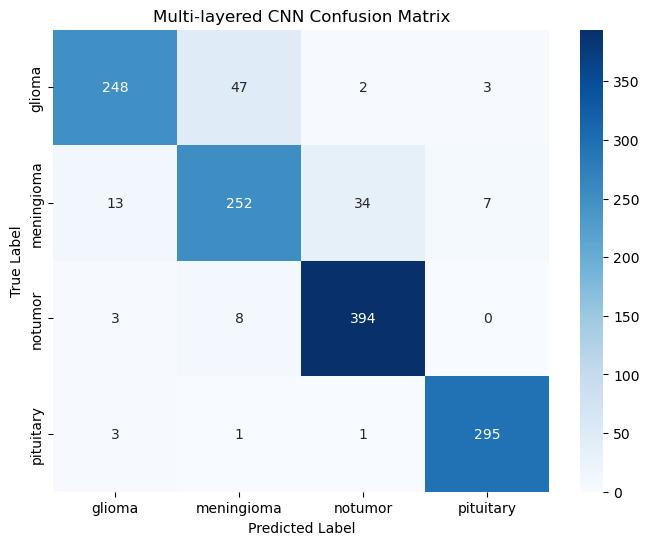

In [35]:
# Confusion Matrix
network.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data, target in testing_generator:
        data = data.to(device)
        target = target.to(device)
        output = network(data)
        pred = output.max(1)[1]
        y_true.extend(target.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multi-layered CNN Confusion Matrix")
plt.show()

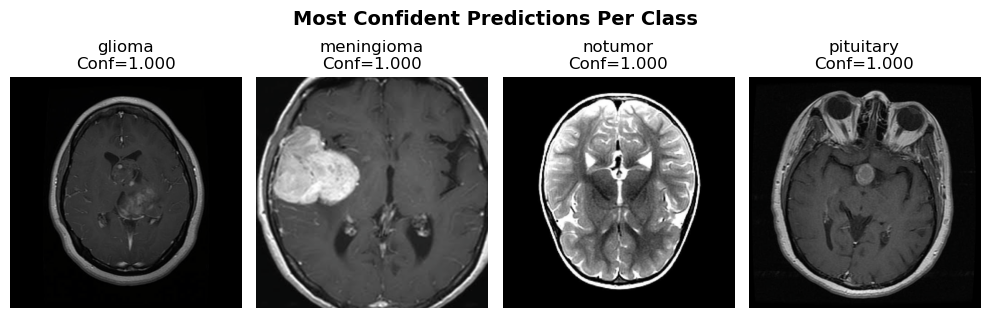

In [36]:
# Most Confident Predictions Per Class
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

class_names = ["glioma","meningioma","notumor","pituitary"]
max_conf = {cls: 0 for cls in range(len(class_names))}
max_image = {cls: None for cls in range(len(class_names))}

network.eval()
with torch.no_grad():
    for inputs, labels in testing_generator:
        inputs = inputs.to(device)
        outputs = network(inputs)
        probs = torch.softmax(outputs, dim=1)

        for i in range(inputs.size(0)):
            for cls in range(len(class_names)):
                conf = probs[i, cls].item()
                if conf > max_conf[cls]:
                    max_conf[cls] = conf
                    max_image[cls] = inputs[i].cpu().numpy()

fig, axes = plt.subplots(1, len(class_names), figsize=(10, 3))

for cls in range(len(class_names)):
    img = max_image[cls]
    img = img.transpose(1, 2, 0)

    # Undo normalization
    img = img * imagenet_std + imagenet_mean
    img = img.clip(0, 1)

    axes[cls].imshow(img)
    axes[cls].set_title(f"{class_names[cls]}\nConf={max_conf[cls]:.3f}")
    axes[cls].axis("off")

plt.tight_layout()
plt.suptitle("Most Confident Predictions Per Class", y=1.1, fontsize=14, fontweight='bold')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1333334].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1333334].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1333334].


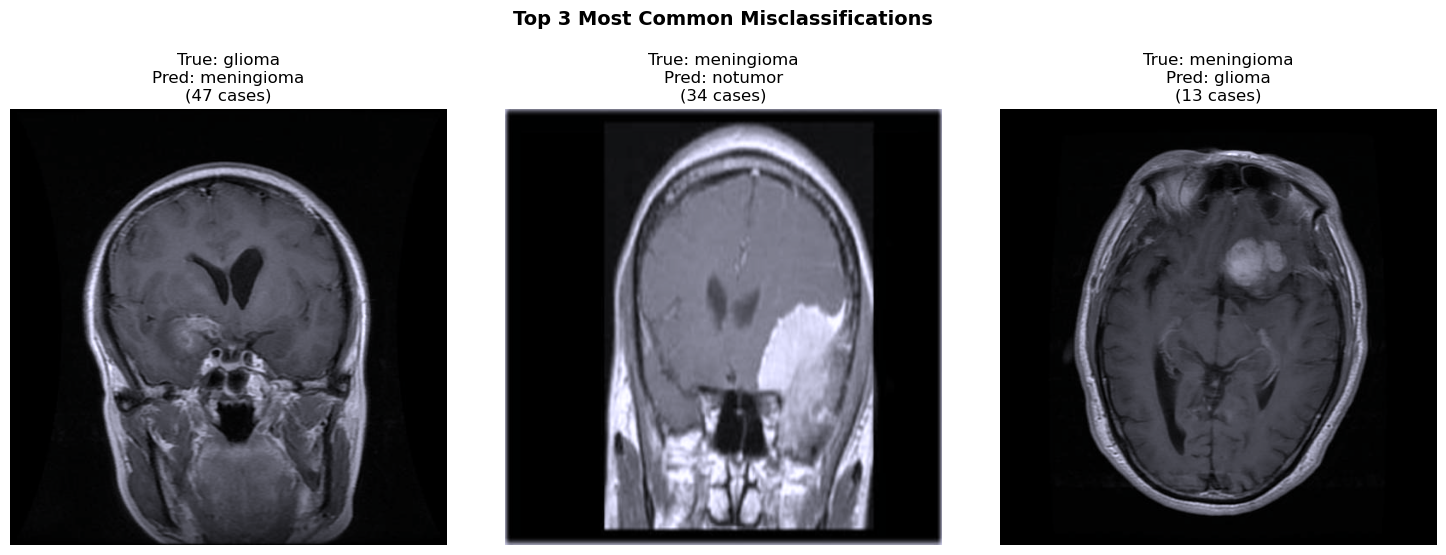

In [37]:
# Top 3 Most Common Misclassifications
y_test = np.array(y_true)
y_pred_array = np.array(y_pred)

unnorm = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

network.eval()
X_test = []
with torch.no_grad():
    for data, target in testing_generator:
        for img in data:
            img = unnorm(img)
            X_test.append(img.cpu().numpy())
X_test = np.array(X_test)

misclass_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and conf_mat[i, j] > 0:
            misclass_pairs.append((conf_mat[i, j], i, j))

misclass_pairs.sort(reverse=True)
top_3_misclass = misclass_pairs[:3]

misclass_examples = {}
for idx in range(len(y_test)):
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    key = (true_label, pred_label)
    if key in [(t, p) for _, t, p in top_3_misclass] and key not in misclass_examples:
        misclass_examples[key] = X_test[idx]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

IMG_SIZE = 512
IMG_CHANNEL = 3

for idx, (count, true_cls, pred_cls) in enumerate(top_3_misclass):
    key = (true_cls, pred_cls)
    if key in misclass_examples:
        img = misclass_examples[key].reshape(IMG_CHANNEL, IMG_SIZE, IMG_SIZE).transpose(1, 2, 0)
        axes[idx].imshow(img)
        axes[idx].set_title(f"True: {class_names[true_cls]}\nPred: {class_names[pred_cls]}\n({count} cases)")
        axes[idx].axis("off")
    else:
        axes[idx].text(0.5, 0.5, 'No example found', ha='center', va='center')
        axes[idx].axis("off")

plt.tight_layout()
plt.suptitle("Top 3 Most Common Misclassifications", y=1.1, fontsize=14, fontweight='bold')
plt.show()

# Pretrained Model

In [38]:
vgg16 = models.vgg16(pretrained=True)

/common/software/install/manual/jupyter_kernels/DeepLearning/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/common/software/install/manual/jupyter_kernels/DeepLearning/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
num_classes = 4
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=1e-4)

In [49]:
VGG_IMG_SIZE = 224 # VGG-16 input size

pretrained_transform = transforms.Compose([
    transforms.Resize((VGG_IMG_SIZE, VGG_IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # ImageNet mean
                         [0.229, 0.224, 0.225]) # ImageNet std
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=pretrained_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=pretrained_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [50]:
vgg16.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/5, Loss: 0.3640
Epoch 2/5, Loss: 0.1057
Epoch 3/5, Loss: 0.0453
Epoch 4/5, Loss: 0.0338
Epoch 5/5, Loss: 0.0161


In [51]:
vgg16.eval()
y_true, y_pred = [], []
y_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = vgg16(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.append(probs.cpu().numpy())

y_prob = np.concatenate(y_probs, axis=0)
y_true = np.array(y_true)
y_pred = np.array(y_pred)


## Results

In [52]:
# General accuracy and class-based precision, recall, and f1-score
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.97      0.88      0.92       300
  meningioma       0.88      0.95      0.92       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



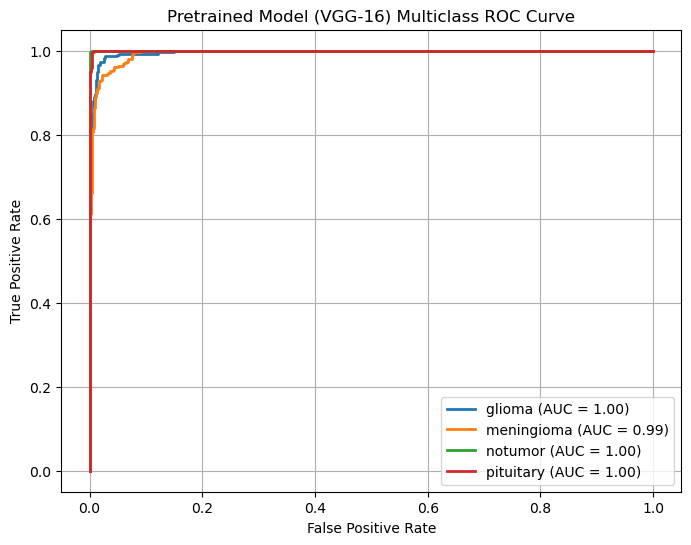

In [53]:
# Class-based ROC AUC graph
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

plt.figure(figsize=(8, 6))

for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC = {roc_auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Pretrained Model (VGG-16) Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


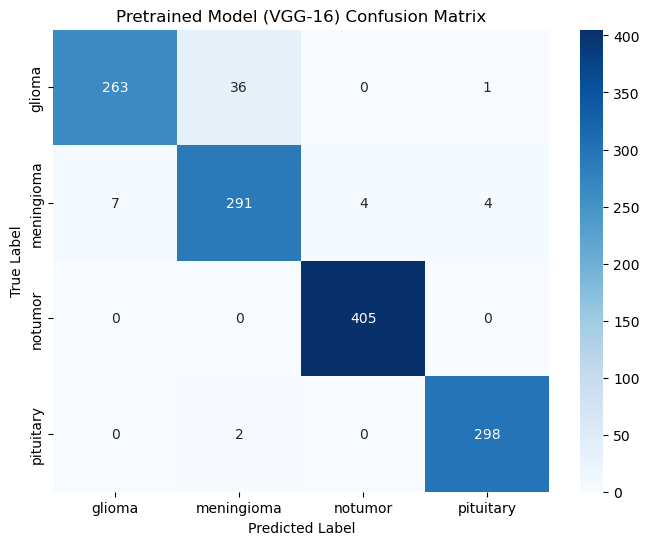

In [54]:
# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Pretrained Model (VGG-16) Confusion Matrix")
plt.show()

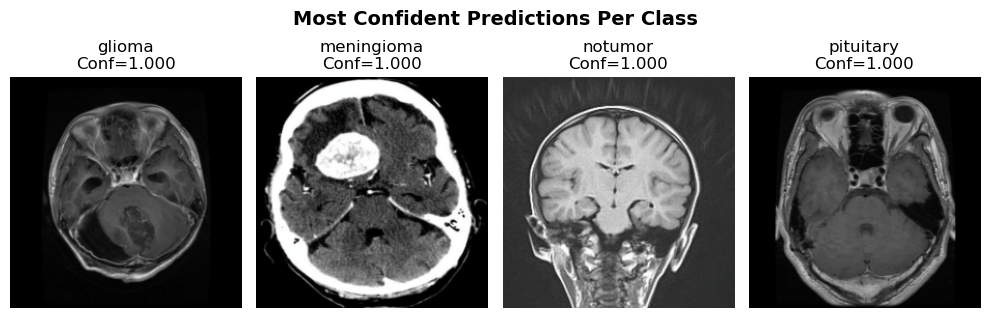

In [55]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

max_conf = {cls: 0 for cls in range(len(class_names))}
max_image = {cls: None for cls in range(len(class_names))}

vgg16.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = vgg16(inputs)
        probs = torch.softmax(outputs, dim=1)

        for i in range(inputs.size(0)):
            for cls in range(len(class_names)):
                conf = probs[i, cls].item()
                if conf > max_conf[cls]:
                    max_conf[cls] = conf
                    max_image[cls] = inputs[i].cpu().numpy()

fig, axes = plt.subplots(1, len(class_names), figsize=(10, 3))

for cls in range(len(class_names)):
    img = max_image[cls]
    img = img.transpose(1, 2, 0)

    # Undo normalization to get clear images
    img = img * imagenet_std + imagenet_mean
    img = img.clip(0, 1)

    axes[cls].imshow(img)
    axes[cls].set_title(f"{class_names[cls]}\nConf={max_conf[cls]:.3f}")
    axes[cls].axis("off")

plt.tight_layout()
plt.suptitle("Most Confident Predictions Per Class", y=1.1, fontsize=14, fontweight='bold')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1333334].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1333334].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1288888].


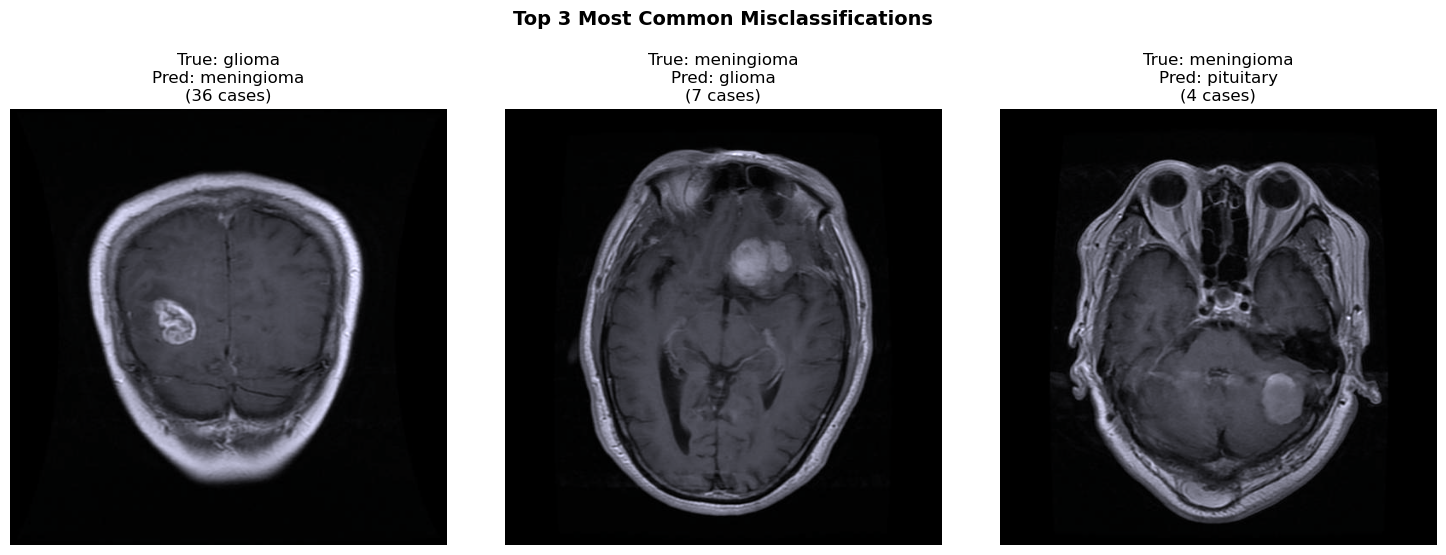

In [56]:
# Top 3 Most Common Misclassifications

misclass_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and conf_mat[i, j] > 0:
            misclass_pairs.append((conf_mat[i, j], i, j))

misclass_pairs.sort(reverse=True)
top_3_misclass = misclass_pairs[:3]

misclass_examples = {}
for idx in range(len(y_test)):
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    key = (true_label, pred_label)
    if key in [(t, p) for _, t, p in top_3_misclass] and key not in misclass_examples:
        misclass_examples[key] = X_test[idx]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (count, true_cls, pred_cls) in enumerate(top_3_misclass):
    key = (true_cls, pred_cls)
    if key in misclass_examples:
        img = misclass_examples[key].reshape(IMG_CHANNELS, IMG_SIZE, IMG_SIZE).transpose(1, 2, 0)
        axes[idx].imshow(img)
        axes[idx].set_title(f"True: {class_names[true_cls]}\nPred: {class_names[pred_cls]}\n({count} cases)")
        axes[idx].axis("off")
    else:
        axes[idx].text(0.5, 0.5, 'No example found', ha='center', va='center')
        axes[idx].axis("off")

plt.tight_layout()
plt.suptitle("Top 3 Most Common Misclassifications", y=1.1, fontsize=14, fontweight='bold')
plt.show()